In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

C:\Users\elsha\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Loading the the data (Step 1)

In [2]:
df = pd.read_csv('../data/jobs_3.csv')
df.head()

,country,title,text,job_title
0,AT,Inform,Information Technology Security Manager Global...,Information Technology Security Manager
1,AT,Architect,Information Security Architect Copmany SWAROVS...,Information Security Architect
2,AT,Manager,Information Technology Security Manager Copman...,Information Technology Security Manager
3,AT,Analyst,Threat Detection Analyst Company Radar Cyber S...,Threat Detection Analyst
4,AT,Engineer,IT Security Engineer Company Global Blue Locat...,IT Security Engineer


In [3]:
df

,country,title,text,job_title
0,AT,Inform,Information Technology Security Manager Global...,Information Technology Security Manager
1,AT,Architect,Information Security Architect Copmany SWAROVS...,Information Security Architect
2,AT,Manager,Information Technology Security Manager Copman...,Information Technology Security Manager
3,AT,Analyst,Threat Detection Analyst Company Radar Cyber S...,Threat Detection Analyst
4,AT,Engineer,IT Security Engineer Company Global Blue Locat...,IT Security Engineer
...,...,...,...,...
264,LV,NaN,Compensa Vienna Insurance Group ADB Latvia is ...,IT Manager/Team lead
265,LV,NaN,Netcracker office in Riga is an integral compo...,IT HelpDesk L2 Engineer
266,LV,NaN,Overview ONE IDENTITY- Software Sales Account ...,Software Sales Account Manager
267,LV,NaN,"The opportunityAt Worldline, our technology ad...",System analyst


### Preprocess the data (Step 2)

In [4]:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for summary in nlp.pipe(df['text']):
    proj_tok= [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [5]:
df['tokens'] = tokens
df['tokens']

0      [information, technology, security, manager, g...
1      [information, security, architect, copmany, sw...
2      [information, technology, security, manager, c...
3      [threat, detection, analyst, company, radar, c...
4      [security, engineer, company, global, blue, lo...
                             ...                        
264    [compensa, vienna, insurance, group, adb, latv...
265    [netcracker, office, riga, integral, component...
266    [overview, software, sales, account, manager, ...
267    [opportunityat, worldline, technology, address...
268    [openstack, complex, challenge, regard, contin...
Name: tokens, Length: 269, dtype: object

### Create dictionary and corpus (Step 3)

In [6]:
dictionary = Dictionary(df['tokens'])

In [7]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

We are now ready to construct the corpus using the dictionary from above and the doc2bow function. The function doc2bow() simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector:


In [8]:
corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

### Model building (Step 4)

In [9]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

#### Calculating the coherence score using C_umass

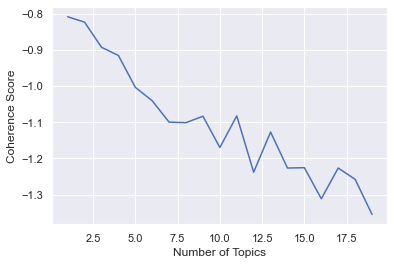

In [15]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

#### Calculating the coherence score using C_v:

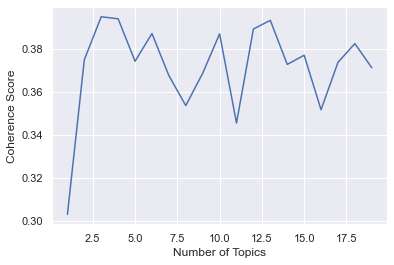

In [13]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig('../figures/cv_description.png')
plt.show()

In [14]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100)

In [15]:
lda_model.print_topics()

[(0,
  '0.016*"product" + 0.014*"customer" + 0.009*"world" + 0.009*"people" + 0.008*"lead" + 0.008*"client" + 0.008*"cloud" + 0.008*"build" + 0.008*"software" + 0.007*"drive"'),
 (1,
  '0.017*"network" + 0.012*"cloud" + 0.012*"tool" + 0.011*"testing" + 0.010*"threat" + 0.010*"engineer" + 0.010*"incident" + 0.010*"infrastructure" + 0.009*"software" + 0.008*"vulnerability"'),
 (2,
  '0.014*"risk" + 0.010*"cyber" + 0.010*"project" + 0.009*"control" + 0.008*"requirement" + 0.008*"activity" + 0.007*"compliance" + 0.007*"relate" + 0.007*"cybersecurity" + 0.007*"international"')]

In [25]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

C:\Users\elsha\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# LDA Topic modelling with job title names

In [22]:
nlp = en_core_web_md.load()
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']

tokens = []
for summary in nlp.pipe(df['job_title']):
    proj_tok= [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

In [ ]:
df['tokens'] = tokens

In [24]:
dictionary = Dictionary(df['tokens'])

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]

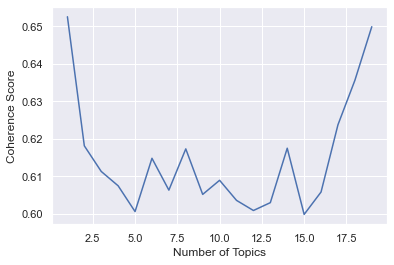

In [ ]:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.savefig('../figures/cv_title.png')
plt.show()

In [27]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100)

In [28]:
lda_model.print_topics()

[(0,
  '0.161*"analyst" + 0.161*"information" + 0.156*"manager" + 0.112*"senior" + 0.068*"product" + 0.046*"researcher" + 0.046*"officer" + 0.035*"technology" + 0.035*"operations" + 0.029*"penetration"'),
 (1,
  '0.216*"cyber" + 0.156*"specialist" + 0.096*"consultant" + 0.096*"cybersecurity" + 0.069*"m" + 0.062*"data" + 0.055*"services" + 0.049*"f" + 0.037*"technical" + 0.036*"automotive"'),
 (2,
  '0.459*"engineer" + 0.117*"architect" + 0.073*"application" + 0.046*"network" + 0.035*"expert" + 0.035*"team" + 0.035*"software" + 0.035*"system" + 0.029*"sales" + 0.029*"support"')]

## Visualisations of the Result (Not ready)

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [36]:
import pyLDAvis.gensim_models
import pickle 
import os
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
num_topics = 7
LDAvis_data_filepath = os.path.join('./'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')
LDAvis_prepared

C:\Users\elsha\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.006888 -0.000939       1        1  57.90446
1      0.004792 -0.003129       2        1  23.94346
0      0.002096  0.004067       3        1  18.15208, topic_info=            Term         Freq        Total Category  logprob  loglift
339     security  2078.000000  2078.000000  Default  30.0000  30.0000
136   experience   817.000000   817.000000  Default  29.0000  29.0000
424         work   559.000000   559.000000  Default  28.0000  28.0000
382   technology   334.000000   334.000000  Default  27.0000  27.0000
381    technical   347.000000   347.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
696     software    44.966671   263.102601   Topic3  -5.7615  -0.0602
426      working    50.377092   335.974374   Topic3  -5.6479  -0.1911
67       company    43.946370   253.120051   Topic3  -5.7845  -0.0445
582          new    43.548739   251.036515   Topic3  -5.7936  -0.0453
128  environment    36.058203   218.571760   Topic3  -5.9823  -0.0956

[275 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
6982      1  0.419486      abap
6982      2  0.419486      abap
6982      3  0.419486      abap
0         1  0.548075   ability
0         2  0.294089   ability
...     ...       ...       ...
7162      2  0.396362       yrs
3238      1  0.666914   zendesk
6049      1  0.419186  zoominfo
6049      2  0.419186  zoominfo
6049      3  0.419186  zoominfo

[531 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])